In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
import nltk
import warnings
warnings.filterwarnings('ignore') 

# # Download NLTK data
# nltk.download('stopwords')
# nltk.download('wordnet')



In [2]:
# Load the dataset
reviews_data = pd.read_csv("result_df.csv")
reviews_data.head()

# 'Text' column contains the cleaned text, and 'Score' column is the label (1/0)
X = reviews_data['Text']  # Input feature (text)
y = reviews_data['Score']  # Target label (1/0)

In [4]:
# Check and remove NaN values
X = X.dropna()
y = y[X.index]

In [4]:
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
#     text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
#     text = text.lower()  # Lowercase the text
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

X = X.apply(preprocess_text)

In [5]:
from tqdm import tqdm

# Download and Load GloVe Embeddings (use 100D for this example)
# You can download GloVe from: https://nlp.stanford.edu/projects/glove/
glove_file = 'glove.6B.300d.txt'  # Replace with your file path

# Load GloVe embeddings
embeddings_index = {}
with open(glove_file, encoding="utf8") as f:
    for line in tqdm(f, desc="Loading GloVe embeddings"):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

Loading GloVe embeddings: 400000it [00:28, 14237.66it/s]

Found 400000 word vectors.


In [6]:
from tqdm import tqdm

def get_glove_embedding(text, embeddings_index, dim=300):
    words = text.split()
    embedding = np.zeros(dim)
    count = 0
    for word in words:
        if word in embeddings_index:
            embedding += embeddings_index[word]
            count += 1
    if count != 0:
        embedding /= count
    return embedding

# Convert all the reviews to GloVe embeddings with progress bar
X_glove = np.array([get_glove_embedding(text, embeddings_index) for text in tqdm(X, desc="Converting text to GloVe embeddings", ncols=100, unit="texts")])

Converting text to GloVe embeddings: 100%|████████████| 243414/243414 [00:17<00:00, 13682.40texts/s]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape

(194731, 300)

In [8]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [12]:
X_train_smote.shape

(323292, 300)

In [9]:
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.29),  # Ensures values between 0.01 and 0.3
    'subsample': uniform(0.7, 0.3),  # Ensures values between 0.7 and 1.0
    'colsample_bytree': uniform(0.7, 0.3)  # Ensures values between 0.7 and 1.0
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=50, scoring='accuracy', 
    cv=3, verbose=1, random_state=42, n_jobs=-1
)
random_search.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024DC034AE80>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024DC034B190>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024DC034A310>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024DC034B430>},
                   random_state=42, scoring='accuracy', verbose=1)

In [11]:
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
print("Best Parameters found by RandomizedSearchCV:", random_search.best_params_)
print("XGBoost Performance:")
print(classification_report(y_test, y_pred))

Best Parameters found by RandomizedSearchCV: {'colsample_bytree': 0.954674147279825, 'learning_rate': 0.21930156113781324, 'max_depth': 9, 'n_estimators': 191, 'subsample': 0.8481386789093172}
XGBoost Performance:
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      8204
           1       0.93      0.92      0.92     40479

    accuracy                           0.88     48683
   macro avg       0.78      0.79      0.78     48683
weighted avg       0.88      0.88      0.88     48683



Best Parameters found by RandomizedSearchCV: {'colsample_bytree': 0.954674147279825, 'learning_rate': 0.21930156113781324, 'max_depth': 9, 'n_estimators': 191, 'subsample': 0.8481386789093172}
Accuracy: 87.51%
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      8204
           1       0.93      0.92      0.92     40479

    accuracy                           0.88     48683
   macro avg       0.78      0.79      0.78     48683
weighted avg       0.88      0.88      0.88     48683



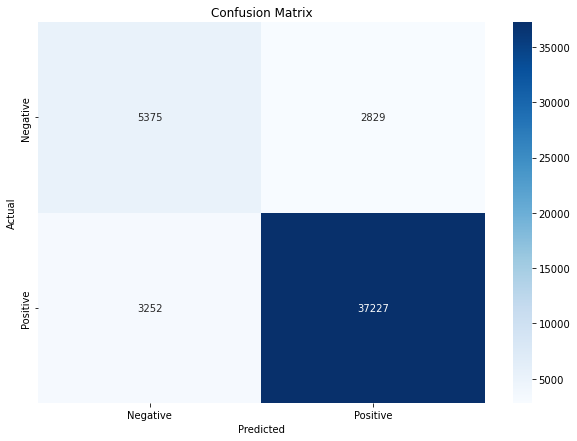

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Print best parameters
print("Best Parameters found by RandomizedSearchCV:", random_search.best_params_)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()